# Evaluating selected cells for melanoma lesion therapy response classification
***
Jan T. Schleicher, 2022

In this notebook, we evaluate the selected cells for classification of melanoma lesions into responders and non-responders. This analysis is based on the data from [Sade-Feldman et al. 2018](https://doi.org/10.1016/j.cell.2018.10.038).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib import patheffects as pe
import seaborn as sns
import os

import enrichment_plots as ep

%config Completer.use_jedi = False
%matplotlib inline
sns.set_theme(style="ticks", font_scale=1.2)

In [2]:
plot_dir = "../output/figures/melanoma_response_status"
os.makedirs(plot_dir, exist_ok=True)

## Plot balanced test accuracies

To choose the best input dimensionality for our model, i.e., the best number of principal components, we look at the balanced accuracies across three random splits of the data.

In [3]:
accuracies = pd.read_csv("../output/model_evaluations/melanoma_response_status_balanced_accuracies.csv")
accuracies.n_PCs = accuracies.n_PCs.astype(str)
accuracies_long = pd.melt(accuracies, id_vars="n_PCs", var_name="accuracy_type", value_name="balanced_accuracy")
accuracies_long["accuracy_type"] = accuracies_long["accuracy_type"].str.replace("_balanced_acc", "")

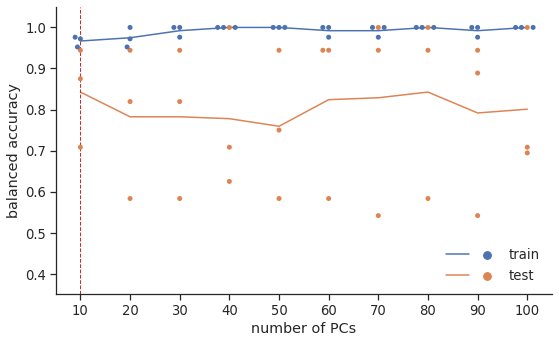

In [4]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(x="n_PCs", y="balanced_accuracy", data=accuracies_long, ax=ax, ci=None,
             hue="accuracy_type", hue_order=["train", "test"])
sns.swarmplot(x="n_PCs", y="balanced_accuracy", data=accuracies_long, ax=ax,
              hue="accuracy_type", hue_order=["train", "test"])
sns.despine()
ax.axvline("10", ls="--", lw=1, c="tab:red")
ax.set_ylim(0.35, 1.05)
ax.set_xlabel("number of PCs")
ax.set_ylabel("balanced accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=["train", "test"], loc="lower right", handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)},
          frameon=False)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, "melanoma_response_status_balanced_accuracies.svg"), dpi=200);

## Loading data

We import the filter response from the CellCnn model for classifying disease status in the COVID-19 data ([Wilk et al. 2021](https://doi.org/10.1084/jem.20210582)). According to the performance evaluation shown above, this is the model that uses 10 principal components as input. We evaluate the model trained on the second training split of the data, which achieved the best balanced test accuracy. The evaluation is performed on training and test data together.

In [5]:
filter_response = pd.read_csv("../output/filter_responses/melanoma_response_status_filter_response.csv",
                             index_col=0)
filter_response["cell_name"] = filter_response.index
meta_data_umap = pd.read_csv("../data/melanoma_umap.txt", index_col=0, sep="\t")
filter_response = filter_response.merge(meta_data_umap[["cell_name", "cluster",
                                                        "UMAP_1", "UMAP_2"]], on="cell_name")
filter_response

,sample_name,patient,response_status,data_set,response_filter_0,response_filter_1,response_filter_2,cell_name,cluster,UMAP_1,UMAP_2
0,Pre_P26,P26,R,train,0.019776,-1.107057,-0.362905,A1_P1_M29_L001,G5,3.147423,0.385581
1,Post_P18,P18,NR,train,-0.106142,-0.684742,-0.503446,A1_P1_M45_L001,G10,-0.792818,1.139232
2,Post_P23_2,P23,NR,train,-0.470107,0.653268,-0.888650,A1_P1_M68_L001,G6,1.881449,-4.454603
3,Pre_P28,P28,R,train,-0.499314,0.043976,-1.359947,A1_P1_M81_L001,G6,-0.889856,-4.745293
4,Post_P5_2,P5,R,train,0.420475,-0.748046,0.363874,A1_P1_MMD1-84B_L001,G5,5.200935,-0.617996
...,...,...,...,...,...,...,...,...,...,...,...
14967,Pre_P24,P24,R,test,0.109699,-0.866249,-0.834237,H9_P7_M82_L001,G10,1.617805,-0.269607
14968,Pre_P24,P24,R,test,0.074795,-0.935054,-0.528919,H9_P8_M82_L001,G10,-0.472703,1.097878
14969,Pre_P24,P24,R,test,-0.491839,-0.168418,-0.658402,H9_P9_M82_L001,G8,0.935139,-2.902143
14970,Post_P28,P28,NR,test,-0.708943,1.579432,-0.969354,H9_P9_M86_L001,G3,-10.012851,-2.727608


## Computing selected cell frequencies per sample

To compare the two classes, we compute the frequencies of cells with a positive filter response per sample. From this, we generate boxplots of selected cell frequencies.

In [6]:
# mark cells with positive filter response as selected
selected_cells_df = filter_response[["sample_name", "response_status"]].copy()
selected_cells_df = selected_cells_df.merge(filter_response.filter(regex="response_filter_\d*$"),
                                            left_index=True, right_index=True)
for i, col in enumerate(selected_cells_df.filter(regex="response_filter_\d*$").columns):
    selected_cells_df[f"selected_filter_{i}"] = (selected_cells_df[col] > 0)

# count selected and total cells per sample
total_cell_counts = selected_cells_df.groupby(["sample_name", "response_status"], observed=True).size()\
    .reset_index(name="count")
selected_cell_counts = selected_cells_df.groupby(["sample_name", "response_status"], observed=True).sum()\
    .filter(regex="selected_filter_\d*$").reset_index()\
    .merge(total_cell_counts, on=["sample_name", "response_status"])

# compute selected cell frequencies per sample
for col in selected_cell_counts.filter(regex="selected_filter_\d*$").columns:
    selected_cell_counts[col + "_freq"] = selected_cell_counts[col] / selected_cell_counts["count"] * 100
selected_cell_counts

,sample_name,response_status,selected_filter_0,selected_filter_1,selected_filter_2,count,selected_filter_0_freq,selected_filter_1_freq,selected_filter_2_freq
0,Post_P1,R,131,26,57,291,45.017182,8.934708,19.587629
1,Post_P10,NR,130,117,22,396,32.828283,29.545455,5.555556
2,Post_P11,NR,144,117,21,313,46.006390,37.380192,6.709265
3,Post_P12,NR,32,182,17,323,9.907121,56.346749,5.263158
4,Post_P13,NR,243,61,139,449,54.120267,13.585746,30.957684
5,Post_P14,NR,128,83,35,329,38.905775,25.227964,10.638298
6,Post_P15,NR,145,34,37,304,47.697368,11.184211,12.171053
7,Post_P16,NR,244,123,31,463,52.699784,26.565875,6.695464
8,Post_P17,R,212,39,148,281,75.444840,13.879004,52.669039
9,Post_P18,NR,249,85,158,357,69.747899,23.809524,44.257703


Selected cell frequencies for filter 0


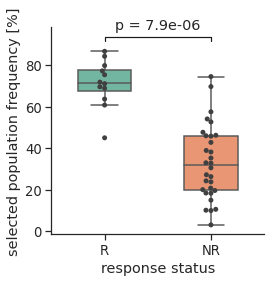

Selected cell frequencies for filter 1


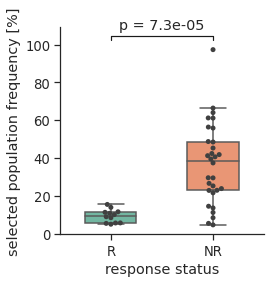

Selected cell frequencies for filter 2


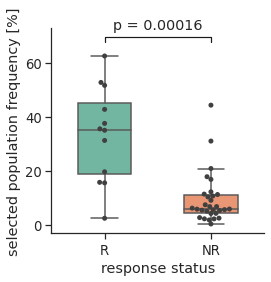

In [7]:
for i, col in enumerate(selected_cell_counts.filter(regex="selected_filter_\d*_freq").columns):
    print(f"Selected cell frequencies for filter {i}")
    ep.plot_selected_cell_frequencies_classification(selected_cells=selected_cell_counts,
                                                     class_col="response_status", class_order=["R", "NR"],
                                                     filter_idx=i, save=True, out_dir=plot_dir)

## Create UMAP plots with filter response

Next, we visualize the cell-wise filter response on the UMAP projection of the data

In [8]:
filter_response[filter_response.filter(regex="response_filter_\d*$").columns] = \
    filter_response.filter(regex="response_filter_\d*$") *\
    (filter_response.filter(regex="response_filter_\d*$") > 0)

UMAP with filter response for filter 0


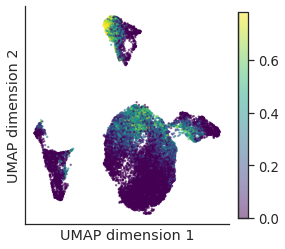

UMAP with filter response for filter 1


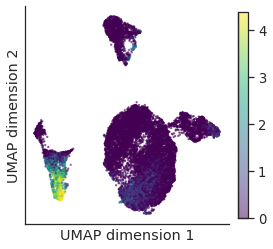

UMAP with filter response for filter 2


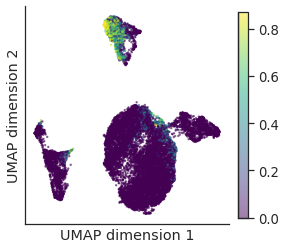

In [9]:
for i, col in enumerate(filter_response.filter(regex="response_filter_\d*$").columns):
    print(f"UMAP with filter response for filter {i}")
    fig, ax = plt.subplots(figsize=(4, 4))

    im = ax.scatter(filter_response["UMAP_1"], filter_response["UMAP_2"], c=filter_response[col],
                    vmin=0, vmax=np.percentile(filter_response[col], 99), cmap="viridis",
                    alpha=.5, edgecolors="face", s=2)
    im.set_rasterized(True)
    plt.colorbar(im, fraction=.046, pad=.04)
    ax.set(xlabel="UMAP dimension 1", ylabel="UMAP dimension 2", xticks=[], yticks=[])
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(plot_dir, f"umap_filter_{i}.svg"), dpi=200)

## Enriched cell types

In the next step, we look at the frequencies and enrichments of different cell types in the selected cells. The threshold for selected cells for each filter is $0.3 \times (\text{maximum filter response})$. We only determine the per-sample frequencies for samples from the majority class among the selected cells.

In [10]:
cluster_colors = {"G1": "#F8766D", "G2": "#DB8E00", "G3": "#AEA200", "G4": "#64B200",
                  "G5": "#00BD5C", "G6": "#00C1A7", "G7": "#00BADE", "G8": "#00A6FF",
                  "G9": "#B385FF", "G10": "#EF67EB", "G11": "#FF63B6"}

Selected cell type enrichments for filter 0
Group R: 
61.22% of all selected cells


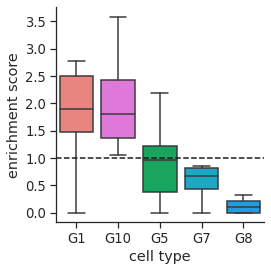

Selected cell type enrichments for filter 1
Group NR: 
98.71% of all selected cells


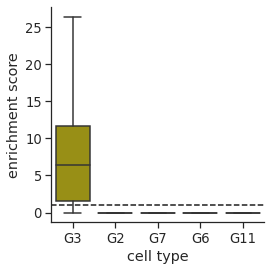

Selected cell type enrichments for filter 2
Group R: 
68.35% of all selected cells


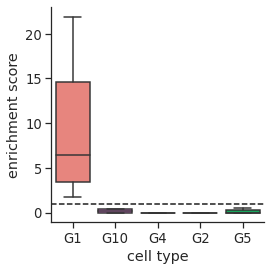

In [11]:
ep.enrichment_per_sample(filter_response, class_col="response_status", sample_col="sample_name",
                         color_dict=cluster_colors, figsize=(4,4), save=True,
                         cell_type_col="cluster", ratio_max_response=.3, out_dir=plot_dir)

Selected cell type frequencies for filter 0
Group R: 
61.22% of all selected cells


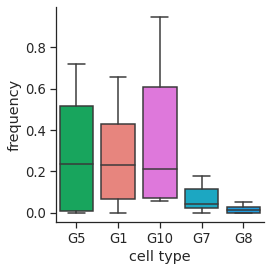

Selected cell type frequencies for filter 1
Group NR: 
98.71% of all selected cells


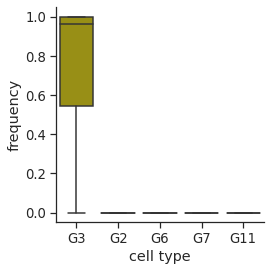

Selected cell type frequencies for filter 2
Group R: 
68.35% of all selected cells


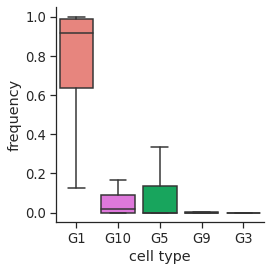

In [12]:
ep.frequency_per_sample(filter_response, class_col="response_status", sample_col="sample_name",
                        color_dict=cluster_colors, figsize=(4,4), save=True,
                        cell_type_col="cluster", ratio_max_response=.3, out_dir=plot_dir)

## Annotated UMAP

Here, we also recreate the annotated UMAP shown in the paper. We use the cell type clusters identified by the original authors ([Sade-Feldman et al. 2018](https://doi.org/10.1016/j.cell.2018.10.038)).

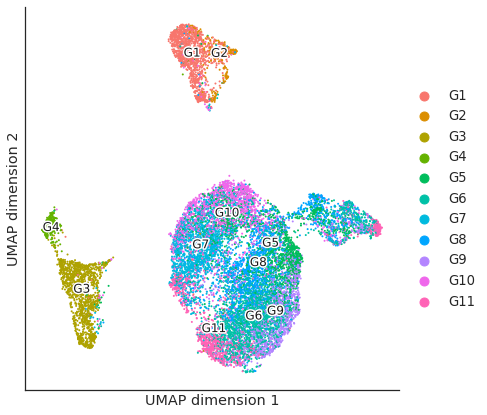

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))

im = sns.scatterplot(x="UMAP_1", y="UMAP_2", hue="cluster",
                     hue_order=list(cluster_colors.keys()),
                     data=meta_data_umap, palette=cluster_colors,
                     linewidth=0, s=4, rasterized=True)
for label in cluster_colors.keys():
    x, y = meta_data_umap.loc[meta_data_umap["cluster"] == label,["UMAP_1", "UMAP_2"]].median()
    ax.annotate(label, (x, y),
                horizontalalignment="center", verticalalignment="center", size=12, color="k",
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set(xlabel="UMAP dimension 1", ylabel="UMAP dimension 2", xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False, markerscale=1.5)
sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, "melanoma_umap_cluster.svg"), dpi=200)